# JAM JENERATION

Starter code taken from this blog post on [jazz improvisation](https://www.hackerearth.com/blog/machine-learning/jazz-music-using-deep-learning/) with [Github repo](https://github.com/shubham3121/music-generation-using-rnn)

In [4]:
import sys
import re 
from collections import Counter

import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
from keras.utils import np_utils

from glob import glob
import IPython
import pickle

import music21

import play # requires pygame installation

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
from music21 import converter, instrument, note, chord, stream

In [3]:
# Any directory with .mid files in here is acceptable. We have 3 in Jazz and 26 in Beethoven.

beethoven_songs = glob('Beethoven/*.mid')
print("Number of songs: {}".format(len(beethoven_songs)))
print(beethoven_songs[:5])

Number of songs: 26
['Beethoven/waldstein_1.mid', 'Beethoven/beethoven_opus90_2.mid', 'Beethoven/waldstein_2.mid', 'Beethoven/beethoven_opus90_1.mid', 'Beethoven/waldstein_3.mid']


In [4]:
mozart_songs = glob('Mozart/*.midi')
print("Number of songs: {}".format(len(mozart_songs)))

Number of songs: 18


# Baseline: Logistic Regression

In this super simple baseline, we ignore chords and pretend that all songs are just sequences of individual notes. Given a window of previous notes, we attempt to predict the next one.

### Extract Notes Simply

In [5]:
def get_simple_notes(songs):
    """
    Returns a list of notes comprising our music.
    For chords in our piece, return the note of our top note.
    i.e. [F#5, C#7, C5, etc.]
    """
    notes = []
    for file in songs:
        # converting .mid file to stream object
        midi = converter.parse(file)
        notes_to_parse = []
        try:
            # Given a single stream, partition into a part for each unique instrument
            parts = instrument.partitionByInstrument(midi)
        except:
            pass
        if parts: # if parts has instrument parts 
            notes_to_parse = parts.parts[0].recurse()
        else:
            notes_to_parse = midi.flat.notes
    
        for element in notes_to_parse: 
            if isinstance(element, note.Note):
                # if element is a note, extract pitch
                notes.append(str(element.pitch))
            elif(isinstance(element, chord.Chord)):
                # if element is a chord, append the first note
                notes.append(str(element.pitches[0]))
        print("Processed song {}".format(file))
    with open('data/simple_notes', 'wb') as filepath:
        pickle.dump(notes, filepath)
    
    return notes

In [6]:
def notes_from_songs(songs):
    notes = get_simple_notes(songs)
    print("Number of notes in dataset: {}".format(len(notes)))
    note_counts = Counter(notes)
    print("Number of distinct notes in dataset: {}".format(len(note_counts)))
    print(note_counts.most_common(3))
    print("Guess-most-common classifier accuracy: {}".format(note_counts.most_common(1)[0][1]/len(notes)))
    return notes

In [7]:
beethoven_notes = notes_from_songs(beethoven_songs)
mozart_notes = notes_from_songs(mozart_songs)

Processed song Beethoven/waldstein_1.mid
Processed song Beethoven/beethoven_opus90_2.mid
Processed song Beethoven/waldstein_2.mid
Processed song Beethoven/beethoven_opus90_1.mid
Processed song Beethoven/waldstein_3.mid
Processed song Beethoven/beethoven_opus10_2.mid
Processed song Beethoven/beethoven_opus10_3.mid
Processed song Beethoven/elise.mid
Processed song Beethoven/beethoven_opus10_1.mid
Processed song Beethoven/beethoven_les_adieux_3.mid
Processed song Beethoven/pathetique_1.mid
Processed song Beethoven/mond_1.mid
Processed song Beethoven/beethoven_les_adieux_2.mid
Processed song Beethoven/mond_3.mid
Processed song Beethoven/pathetique_2.mid
Processed song Beethoven/pathetique_3.mid
Processed song Beethoven/mond_2.mid
Processed song Beethoven/beethoven_les_adieux_1.mid
Processed song Beethoven/beethoven_opus22_1.mid
Processed song Beethoven/beethoven_opus22_2.mid
Processed song Beethoven/beethoven_hammerklavier_4.mid
Processed song Beethoven/beethoven_opus22_3.mid
Processed son

### Prepare Logistic Regression Sequences

In [8]:
def one_hot_encoding(note, note_to_int):
    """ Returns one-hot encoded vector given note, dictionary from notes to indices """
    n_vocab = len(note_to_int)
    one_hot = np.zeros(n_vocab)
    note_idx = note_to_int[note]
    one_hot[note_idx] = 1
    return one_hot

In [50]:
def prepare_simple_sequences(notes, sequence_length):
    """
    Prepares vectors of simple notes for one-hot encoding input into LogisticRegression classifer
    
    returns X, y
    X: a list of training examples, where each training example are concatenations of one-hot encodings
        Each training input in X is thus (sequence_length * n_vocab) in length
    y: a list of notes. Each note corresponds to the next note in corresponding sequence from X
    """

    # Extract the unique pitches in the list of notes.
    pitchnames = sorted(set(item for item in notes))
    n_vocab = len(pitchnames)

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    # Slide a window over our notes, adding sequences to dataset
    X, y = [], []
    for i in range(0, len(notes) - sequence_length):
        sequence_in = notes[i : i + sequence_length]
        sequence_in = [one_hot_encoding(n, note_to_int) for n in sequence_in]
        sequence_in = np.concatenate(sequence_in, axis=None)
        note_out = notes[i + sequence_length]
        X.append(sequence_in)
        y.append(note_out)
    
    # TODO: Should we turn our labels into categorical one-hot encodings using np_utils.to_categorical
    # TODO: Should we normalize input?
    return X, y, note_to_int

In [51]:
def get_XY(notes):
    simple_sequence_length = 10
    simple_X, simple_y, note_to_int = prepare_simple_sequences(notes, simple_sequence_length)
    print("Sequence length: {}".format(simple_sequence_length))
    print("Number of distinct notes: {}".format(len(set(notes))))
    print("Number of training examples: {}".format(len(simple_X)))
    print("First five output notes: {}".format(simple_y[:5]))
    return simple_X, simple_y, note_to_int

In [52]:
beethoven_X, beethoven_y, beethoven_note_to_int = get_XY(beethoven_notes)

Sequence length: 10
Number of distinct notes: 78
Number of training examples: 74593
First five output notes: ['G2', 'C3', 'G2', 'C3', 'G2']


In [53]:
mozart_X, mozart_y, mozart_note_to_int = get_XY(mozart_notes)

Sequence length: 10
Number of distinct notes: 60
Number of training examples: 47735
First five output notes: ['C4', 'E-4', 'C4', 'A4', 'E-4']


Note that the following train-test split procedure could be somewhat flawed. We don't split on unseen (unheard) songs, so a melody that appears multiple times in one song could be picked up later on in the model.

In [54]:
def get_train_test(simple_X, simple_y, test_size=0.15):
    simple_X_train, simple_X_test, simple_y_train, simple_y_test = train_test_split(simple_X, simple_y, test_size=test_size)
    simple_y_train[:5]
    print("Train set size: {}".format(len(simple_y_train)))
    print("Test set size: {}".format(len(simple_y_test)))
    return simple_X_train, simple_X_test, simple_y_train, simple_y_test

In [55]:
beethoven = get_train_test(beethoven_X, beethoven_y)

Train set size: 63404
Test set size: 11189


In [56]:
mozart = get_train_test(mozart_X, mozart_y)

Train set size: 40574
Test set size: 7161


In [57]:
combined_X, combined_y, combined_note_to_int = get_XY(beethoven_notes + mozart_notes)

Sequence length: 10
Number of distinct notes: 78
Number of training examples: 122338
First five output notes: ['G2', 'C3', 'G2', 'C3', 'G2']


In [58]:
combined = get_train_test(combined_X, combined_y)

Train set size: 103987
Test set size: 18351


### Train Simple Logistic Regression/SVM Multi-Class Classification Model

In this simpler problem, we assume that each sequence of notes has one and only one note succeeding it. This makes it a multi-class classification problem.

Later we'll have to expand it to multi-label problem for chords.

In [89]:
# dataset should be tuple/list of X_train, X_test, y_train, y_test
def run_logreg(dataset, c=1.0):
    X_train, X_test, y_train, y_test = dataset
    logreg = LogisticRegression(C=c, penalty='l2')
    logreg.fit(X_train, y_train)
    lr_preds_test = logreg.predict(X_test)
    print(sklearn.metrics.accuracy_score(lr_preds_test, y_test))

In [90]:
run_logreg(beethoven)

/Users/etang/dev/jam-jeneration/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/etang/dev/jam-jeneration/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.28608454732326394


In [20]:
run_logreg(mozart)

0.2987012987012987


In [40]:
run_logreg(combined)

0.2609667048117269


In [ ]:
# run_logreg(beethoven, 0.3)
# run_logreg(beethoven, 10)
# run_logreg(beethoven, 100)

In [32]:
run_logreg(mozart, 0.1)
run_logreg(mozart, 0.3)
run_logreg(mozart, 10)
run_logreg(mozart, 100)

0.26853791369920404
0.28515570451054323
0.2964669738863287
0.2992598799050412


In [15]:
lr_preds_test = logreg.predict(simple_X_test)
sklearn.metrics.accuracy_score(lr_preds_test, simple_y_test)

0.28608454732326394

In [ ]:
logreg2 = LogisticRegression()
logreg2.fit(simple_X_train, simple_y_train)
lr2_preds_test = logreg.predict(simple_X_test)
sklearn.metrics.accuracy_score(lr2_preds_test, simple_y_test)

In [ ]:
logreg3 = LogisticRegression()
logreg2.fit(simple_X_train, simple_y_train)
lr2_preds_test = logreg.predict(simple_X_test)
sklearn.metrics.accuracy_score(lr2_preds_test, simple_y_test)

In [ ]:
svm = SVC()
svm.fit(simple_X_train, simple_y_train)
svm_preds = svm.predict(simple_y_test)
sklearn.metrics.accuracy_score(svm_preds, simple_y_test)

### Hyperparameter optimization

In [43]:
param_grid = [
  {'C': [0.3, 1, 10, 50]} # , 'penalty': ['l1', 'l2']
 ]

In [ ]:
gs = GridSearchCV(LogisticRegression(), param_grid, verbose=1)
gs.fit(simple_X_train, simple_y_train)

print("Best parameters set found on train set:")
print(clf.best_params_)

print("Grid scores on train set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


### Composing!

In which we attempt to use our previous work to generate a melody and play it.

Work in progress. We display and show notes, but haven't yet done the heavy lifting of actually composing.

In [13]:
def stream_for_note_list(note_list):
    """
    Returns a music21 stream given a list of notes ['A5', 'C#4', 'E#3']
    This should allow us to show and play a 
    """
    s = stream.Stream()
    for n in note_list:
        s.append(note.Note(n))
    return s

In [29]:
def play_stream(our_stream, save_path=None):
    """
    Displays notes, plays audio, saves MIDI file for a given music21 stream object
    """
    # We use music21 to read in notes, play.py to play music
    # Unfortunately, music21 midi player doesn't work with Jupyter so we use play.py
    our_stream.show()
    save_path = save_path or 'output/temp_stream.midi'
    our_stream.write('midi', save_path)
    play.play_midi(save_path)

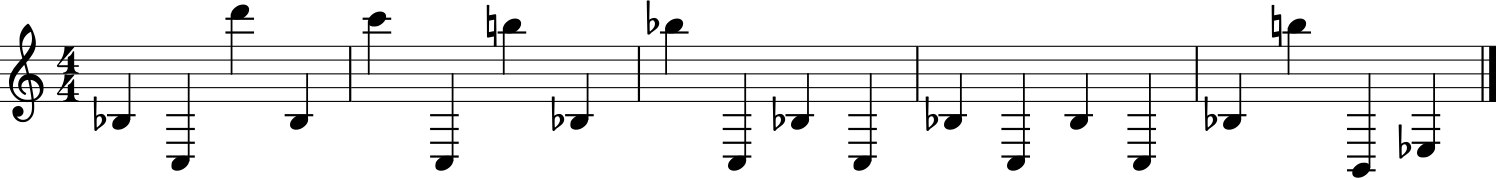

Music file output/temp_stream.midi loaded!


In [32]:
simple_stream = stream_for_note_list(simple_notes[400:420])
play_stream(simple_stream)

# LSTM Models

(Work in Progress)

In [6]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
def create_network(network_in, n_vocab): 
    """Create the model architecture"""
    model = Sequential()
    model.add(LSTM(128, input_shape=(100,1), return_sequences=True)) # network_in.shape[1:]
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
#     print(network_in.shape[1:])

    return model

# Original jazz rnn code:

## Extracting Chords and Notes

In [19]:
mozart_songs = glob('Mozart/*.midi')
print("Number of songs: {}".format(len(mozart_songs)))

Number of songs: 18


In [20]:
def get_notes(songs):
    notes = []
    for file in songs:
        # converting .mid file to stream object
        midi = converter.parse(file)
        notes_to_parse = []
        try:
            # Given a single stream, partition into a part for each unique instrument
            parts = instrument.partitionByInstrument(midi)
        except:
            pass
        if parts: # if parts has instrument parts 
            notes_to_parse = parts.parts[0].recurse()
        else:
            notes_to_parse = midi.flat.notes
    
        for element in notes_to_parse: 
            if isinstance(element, note.Note):
                # if element is a note, extract pitch
                notes.append(str(element.pitch))
            elif(isinstance(element, chord.Chord)):
                # if element is a chord, append the normal form of the 
                # chord (a list of integers) to the list of notes. 
                notes.append('.'.join(str(n) for n in element.normalOrder))
    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)
    
    return notes

In [21]:
get_notes(mozart_songs)[145:155]

['A3', 'F4', 'F3', 'A4', 'D5', 'A3', 'A4', 'F3', 'D5', 'F5']

## Preparing Sequence Vectors

In [7]:
def prepare_sequences(notes, n_vocab): 
    sequence_length = 100

    # Extract the unique pitches in the list of notes.
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i: i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    
    n_patterns = len(network_input)
    
    # reshape the input into a format comatible with LSTM layers 
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    
    # one hot encode the output vectors
    network_output = np_utils.to_categorical(network_output)
    
    return (network_input, network_output)

## LSTM Model

In [8]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
def create_network(network_in, n_vocab): 
    """Create the model architecture"""
    model = Sequential()
    model.add(LSTM(128, input_shape=(100,1), return_sequences=True)) # network_in.shape[1:]
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
#     print(network_in.shape[1:])

    return model

In [9]:
from keras.callbacks import ModelCheckpoint
def train(model, network_input, network_output, epochs): 
    """
    Train the neural network
    """
    # Create checkpoint to save the best model weights.
    filepath = 'weights.best.mozart.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    
    model.fit(network_input, network_output, epochs=epochs, batch_size=64, callbacks=[checkpoint])

In [10]:
def train_network(songs):
    """
    Get notes
    Generates input and output sequences
    Creates a model 
    Trains the model for the given epochs
    """
    
    epochs = 30
    
    notes = get_notes(songs)
    print('Notes processed')
    
    n_vocab = len(set(notes))
    print('Vocab generated')
    
    network_in, network_out = prepare_sequences(notes, n_vocab)
    print('Input and Output processed')
    
    model = create_network(network_in, n_vocab)
    print('Model created')
#     return model
    print('Training in progress')
    train(model, network_in, network_out, epochs)
    print('Training completed')
    
    return model
    

In [6]:
### Train the model 
model = train_network(mozart_songs)

NameError: name 'mozart_songs' is not defined

## Composition

In which we take a model and actually generate music!

In [11]:
def generate(model=None):
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))
    
    print('Initiating music generation process.......')
    
    network_input = get_inputSequences(notes, pitchnames, n_vocab)
    
#             reshaped_input = np.reshape(pattern, (1, len(pattern), 1))
#         prediction_input = prediction_input / float(n_vocab)
        
    if not model:
        model = create_network(network_input, n_vocab)
        print('Loading Model weights.....')
        model.load_weights('weights.best.music3.hdf5')
    else:
        print('Using given model')
    
    print('Model Loaded')
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

In [12]:
def get_inputSequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])

    return network_input, note_to_int

In [13]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # Pick a random integer
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    
    # pick a random sequence from the input as a starting point for the prediction
    pattern = network_input[start]
    prediction_output = []
    
    print('Generating notes........')

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)
        
        # Predicted output is the argmax(P(h|D))
        index = np.argmax(prediction)
        # Mapping the predicted interger back to the corresponding note
        result = int_to_note[index]
        # Storing the predicted output
        prediction_output.append(result)

        pattern.append(index)
        # Next input to the model
        pattern = pattern[1:len(pattern)]

    print('Notes Generated...')
    return prediction_output

In [14]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    
    print('Saving Output file as midi....')

    midi_stream.write('midi', fp='models/beethoven_30e_output.midi')

In [74]:
#### Generate a new jazz music 
generate(model)

NameError: name 'model' is not defined

In [75]:
### Play the Jazz music
play.play_midi('models/beethoven_5e_output.midi')

File models/beethoven_5e_output.midi not found! (Couldn't open 'models/beethoven_5e_output.midi')


## Saved model

In [15]:
def load_saved():
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)
    n_vocab = len(set(notes))
    pitchnames = sorted(set(item for item in notes))
    network_input, note_to_int = get_inputSequences(notes, pitchnames, n_vocab)
    print("Number of distinct notes: {}".format(n_vocab))
    #print(network_input)
    
    model = create_network(network_input, 275) #n_vocab = 193
    print('Loading Model weights.....')
    model.load_weights('weights.best.beethoven.hdf5')
    return model

In [16]:
saved_lstm_model = load_saved()
saved_lstm_model.summary()

Number of distinct notes: 193
Loading Model weights.....
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)    

In [20]:
def test_lstm(model):
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)
    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))    
    network_input, note_to_int = get_inputSequences(notes, pitchnames, n_vocab)
    network_input = np.array(network_input)
    network_input = network_input.reshape((-1, 100, 1))
    print(network_input.shape)
    print("Initial input: ", network_input[0])
    int_to_note = {v : k for k, v in note_to_int.items()}
    print("Initial input as notes: ", np.vectorize(lambda i: int_to_note[i])(network_input[0]))
    preds_test = model.predict(network_input)
    print("Initial output: ", preds_test[0])
    return int_to_note

In [21]:
int_to_note = test_lstm(saved_lstm_model)

(47645, 100, 1)
Initial input:  [[182]
 [181]
 [138]
 [158]
 [138]
 [139]
 [158]
 [138]
 [159]
 [181]
 [158]
 [168]
 [158]
 [139]
 [168]
 [158]
 [144]
 [181]
 [143]
 [163]
 [143]
 [192]
 [163]
 [143]
 [183]
 [181]
 [174]
 [190]
 [174]
 [143]
 [190]
 [143]
 [190]
 [183]
 [ 91]
 [139]
 [164]
 [191]
 [159]
 [139]
 [182]
 [181]
 [137]
 [162]
 [191]
 [189]
 [173]
 [182]
 [157]
 [173]
 [163]
 [173]
 [137]
 [139]
 [182]
 [180]
 [144]
 [162]
 [164]
 [142]
 [164]
 [137]
 [159]
 [144]
 [139]
 [191]
 [162]
 [182]
 [191]
 [142]
 [144]
 [ 71]
 [157]
 [ 91]
 [180]
 [160]
 [125]
 [145]
 [105]
 [140]
 [ 91]
 [140]
 [ 91]
 [140]
 [ 91]
 [192]
 [104]
 [183]
 [ 91]
 [183]
 [ 91]
 [183]
 [ 91]
 [ 74]
 [104]
 [ 74]
 [104]
 [ 74]
 [104]
 [ 74]]
Initial input as notes:  [['F4']
 ['F3']
 ['A3']
 ['C4']
 ['A3']
 ['A4']
 ['C4']
 ['A3']
 ['C5']
 ['F3']
 ['C4']
 ['E-4']
 ['C4']
 ['A4']
 ['E-4']
 ['C4']
 ['B-4']
 ['F3']
 ['B-3']
 ['D4']
 ['B-3']
 ['G5']
 ['D4']
 ['B-3']
 ['F5']
 ['F3']
 ['E5']
 ['G3']
 ['E5']
 ['B

## Extract Notes' Vector Embeddings

Motivation comes from this paper ( http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/ ) on extracting word vector embeddings from a neural network trained to predict proximate words. In this model, to find the embedding for note, say, 'A5', we feed in a sequence entirely composed of 'A5', then extract the resulting activations of the penultimate layer (a 256 x 1 layer). The logic is that similar notes (for some definition of similar) will share similar latent features that get picked up in this penultimate layer.

For documentation, see https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

In [23]:
from keras import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Construct a new model which outputs the output from penultimate layer.
penultimate_layer_model = Model(inputs=saved_lstm_model.input, outputs=saved_lstm_model.get_layer('dense_1').output) 

In [24]:
def penultimate_layers_notes(layer_model, int_to_note):
    
    # Extract Embeddings from Penultimate Layer
    note_indices = np.array([i for i,n in int_to_note.items()])
    note_names = np.array([int_to_note[i] for i in note_indices])
    print("First note_names: {}, first note_indices: {}".format(note_names[:10], note_indices[:10]))
    input_shape = (100, 1)
    network_in = [i * np.ones(input_shape) for i in note_indices]
    network_in = np.array(network_in)
    print("Network_in shape: {}".format(network_in.shape))
    embeddings = layer_model.predict(network_in)
    print("Sample embedding shape: {}".format(embeddings[0].shape))
    
    # Apply PCA to Extracted Embeddings
    print("Applying PCA to embeddings...")
    pca = PCA(n_components=2)
    pca.fit(embeddings)
    pca_embeddings = pca.transform(embeddings)
    print("Explained variance ratios of first two PCA components: {}".format(pca.explained_variance_ratio_))
    
    # Plot PCA Visualization
#     fig, ax = plt.subplots(figsize=(100, 100))
    plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1])
#     for i, name in enumerate(note_names):
#         plt.annotate(name, (pca_embeddings[0], pca_embeddings[1]))

First note_names: ['0' '0.1' '0.2' '0.2.6' '0.2.7' '0.3' '0.3.5' '0.3.6' '0.3.6.9' '0.3.7'], first note_indices: [0 1 2 3 4 5 6 7 8 9]
Network_in shape: (193, 100, 1)
Sample embedding shape: (256,)
Applying PCA to embeddings...
Explained variance ratios of first two PCA components: [0.83853084 0.11776968]


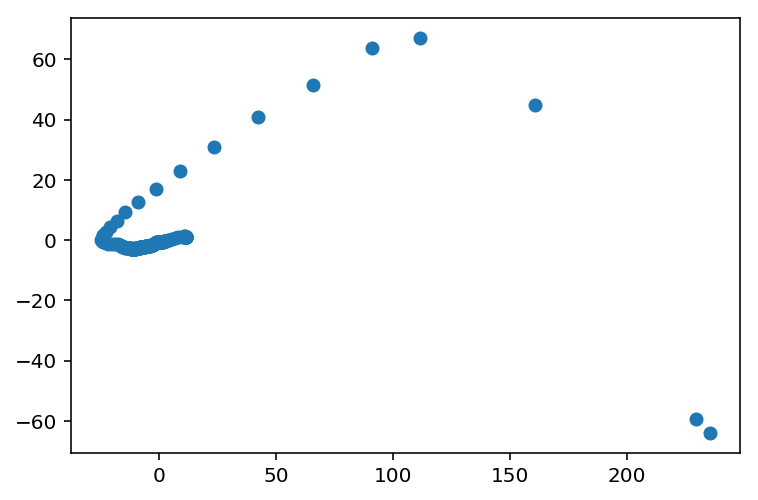

In [25]:
penultimate_layers_notes(penultimate_layer_model, int_to_note)